In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from copy import deepcopy
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from os.path import join as oj
import sys
import acd
from tqdm import tqdm
import pickle as pkl
import torchvision
import numpy as np
import models
import time
from sklearn.metrics import r2_score
sys.path.append('..')
sys.path.append('../trim')
sys.path.append('../util')
from functools import partial
from transforms_torch import bandpass_filter
from data import *
from style import *
data_path = '/scratch/users/vision/data/cosmo'
torch.manual_seed(42)
np.random.seed(42)
mnu_dataset = MassMapsDataset(oj(data_path, 'cosmological_parameters.txt'),  oj(data_path, 'z1_256'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

m = models.load_model(model_name='resnet18', device=device)

data_transform = transforms.Compose([ToTensor()])
dataloader = torch.utils.data.DataLoader(MassMapsDataset(oj(data_path, 'cosmological_parameters.txt'),  
                                                         oj(data_path, 'z1_256'),
                                                         transform=data_transform), 
                                         batch_size=64, shuffle=True, num_workers=4)

**check that it makes reasonable preds**

100%|██████████| 100/100 [00:02<00:00, 38.86it/s]


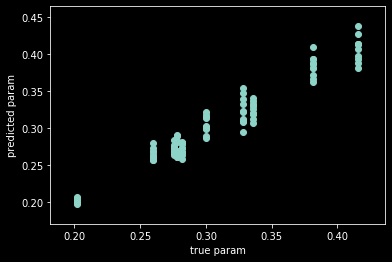

In [5]:
with torch.no_grad():
    result = {'y': [], 'pred': []}
    for i in tqdm(range(100)):
        sample = data_transform(mnu_dataset[i])
        x = sample['image']
        result['y'].append(sample['params'][1].item())
        result['pred'].append(m(x.unsqueeze(0).to(device)).flatten()[1].item())
# print(result)
plt.scatter(result['y'], result['pred'])
plt.xlabel('true param')
plt.ylabel('predicted param')
plt.show()

In [6]:
r2_score(result['y'], result['pred'])

0.9518652710908944

# calc cd scores

**calc cd scores**

In [ ]:
def calc_scores(im_t, model_ft, transform, device='cuda', band_centers=np.linspace(0.1, 0.90, 100)):
    '''Calculate scores across many bands
    '''
    with torch.no_grad():
        x = deepcopy(im_t).to(device)
        model_ft = model_ft.to(device)
        scores = []
        for band_center in band_centers:
            score = acd.cd(x, model_ft, mask=None, model_type='resnet18', 
                           device=device, transform=partial(transform, band_center=band_center, band_width=0.05))
            score = score[0].flatten().detach().cpu().numpy()
            scores.append(score)
        pred = model_ft(x).flatten().detach().cpu().numpy()
    return pred, scores



band_centers = np.linspace(0.1, 0.90, 100)
np.random.seed(42)
results = {
    'scores_list': [],
    'preds_list': []
}
for sample_num in tqdm(range(1000)):
    sample = mnu_dataset[sample_num]
    im = np.squeeze(sample['image']).astype(np.float32)
    im_t = torch.Tensor(im).reshape(1, 1, 256, 256)    
    class_num = 1 # output is: [M_nu(eV), Omega_m 10^9*A_s, sigma_8(derived)]
    pred, scores = calc_scores(im_t, m, bandpass_filter, band_centers=band_centers)
    results['scores_list'].append(deepcopy(scores)) #, class_num=1))
    results['preds_list'].append(deepcopy(pred))
    if sample_num % 10 == 0:
        pkl.dump({
            'scores_list': np.array(results['scores_list']),
            'preds_list': np.array(results['preds_list']),
        }, open(f'results/scores_list_{sample_num}.pkl', 'wb'))

# visualize the model's filters

In [13]:
w1 = m.state_dict()['conv1.weight'].cpu().numpy().squeeze()

In [ ]:
R, C = 8, 8
plt.figure(dpi=100, figsize=(8, 8))
for i in range(64):
    plt.subplot(R, C, i + 1)
    plt.imshow(w1[i], interpolation='bilinear')
    plt.axis('off')
plt.tight_layout()